In [1]:
# import required modules:
import matplotlib.pyplot as plt # to make plots
import numpy as np # for array manipulation and math functions
import scipy.signal as scs # for signal analysis
import glob # for finding files
import os as os
import warnings
import array as arr
from scipy import optimize
from scipy.optimize import curve_fit
# import fit models from the lmfit package
from lmfit.models import ExponentialModel, GaussianModel, PolynomialModel
# insert the path to your Data here5
datapath = "./Daten/"
# Konstanten
c0                  = 299792458             # Vakuum Lichtgeschwindigkeit
#h                   = 6.626e-34             # Plank'sches Wirkungsquantum
hbar                = 6.626e-34/(2*np.pi)   # Reduzierte Plank-Konstante
e                  = 1.6022e-19            # Elektronenvolt
pathlist= glob.glob(datapath+"*.txt")
print(pathlist)
pathlist[0], pathlist[1], pathlist[2]=pathlist[2],pathlist[1],pathlist[0]
print(pathlist)

['./Daten/Blau2.txt', './Daten/rot.txt', './Daten/Turkis.txt']
['./Daten/Turkis.txt', './Daten/rot.txt', './Daten/Blau2.txt']


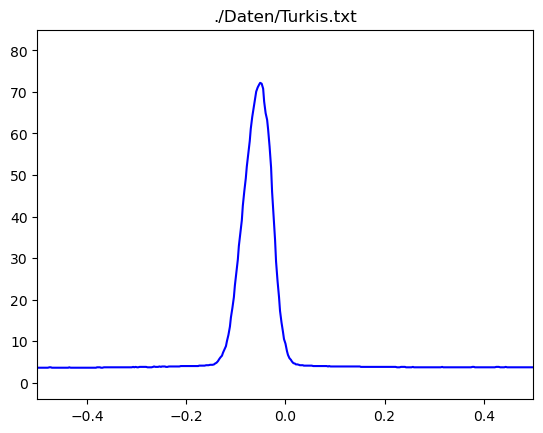

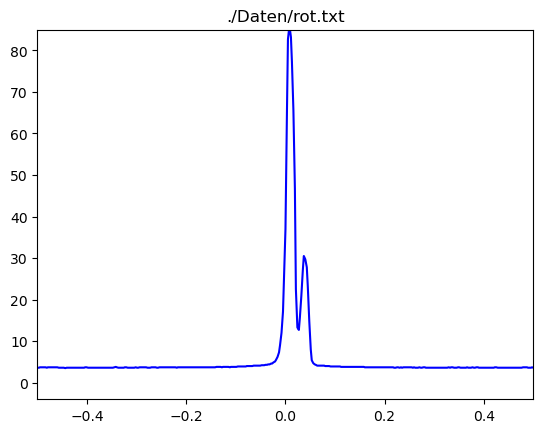

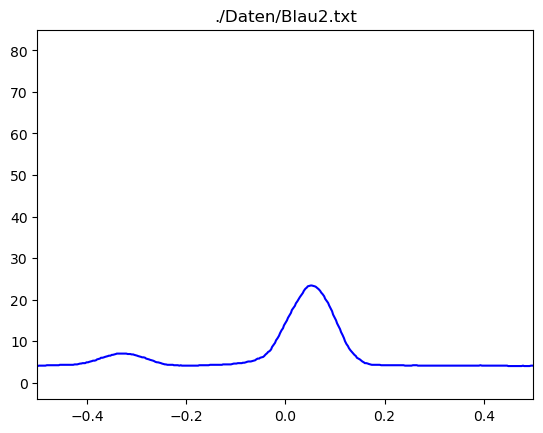

In [2]:
data=[]
winkel=[]
Intensity=[]
count=0
rang=[]
for p in pathlist:
    with open(str(p), 'r') as file:
        filedata = file.read()
        
    # Replace the target string
    filedata = filedata.replace(',', '.')

    # Write the file out again
    with open(str(p), 'w') as file:
        file.write(filedata)
    data.append(np.loadtxt(str(p)))
    winkel.append(data[count][:,0])
    Intensity.append(data[count][:,1])
    plt.figure()
    plt.title(str(p))
    plt.plot(winkel[count],Intensity[count],'b-')
    plt.axis([-0.5,0.5, -4, 85])
    plt.show
    count=count+1

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 225
    # data points      = 2048
    # variables        = 6
    chi-square         = 34.4270512
    reduced chi-square = 0.01685948
    Akaike info crit   = -8355.66998
    Bayesian info crit = -8321.92227
    R-squared          = 0.99959799
[[Variables]]
    g1_amplitude:  3.78494801 +/- 0.02769725 (0.73%) (init = 1)
    g1_center:    -0.06251778 +/- 1.8782e-04 (0.30%) (init = -0.006)
    g1_sigma:      0.02681608 +/- 6.4605e-05 (0.24%) (init = 0.05)
    g2_amplitude:  0.94382433 +/- 0.02683724 (2.84%) (init = 0.5)
    g2_center:    -0.03792916 +/- 7.4384e-05 (0.20%) (init = -0.045)
    g2_sigma:      0.01578556 +/- 1.3913e-04 (0.88%) (init = 0.01)
    g1_fwhm:       0.06314704 +/- 1.5213e-04 (0.24%) == '2.3548200*g1_sigma'
    g1_height:     56.3085967 +/- 0.30307279 (0.54%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_

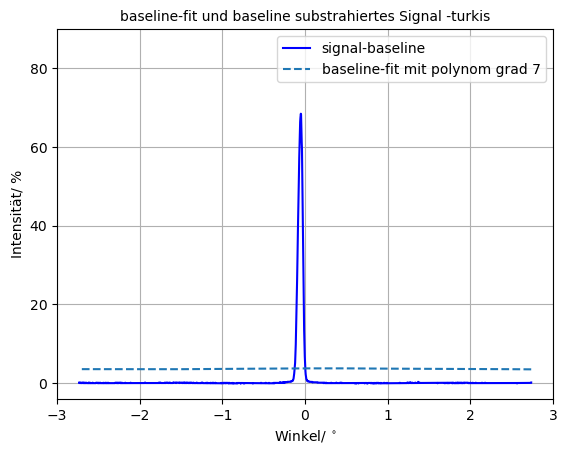

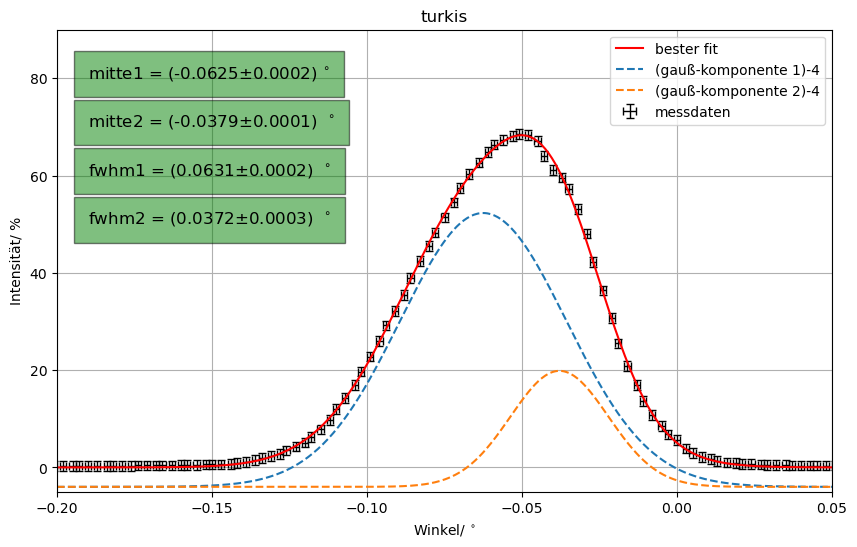

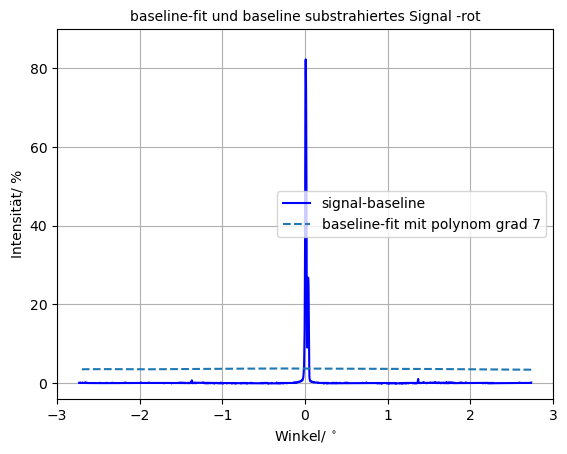

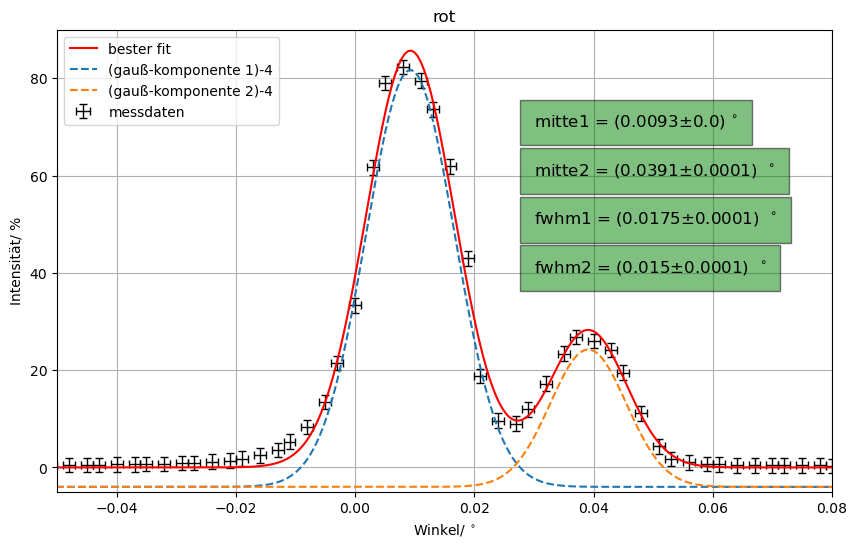

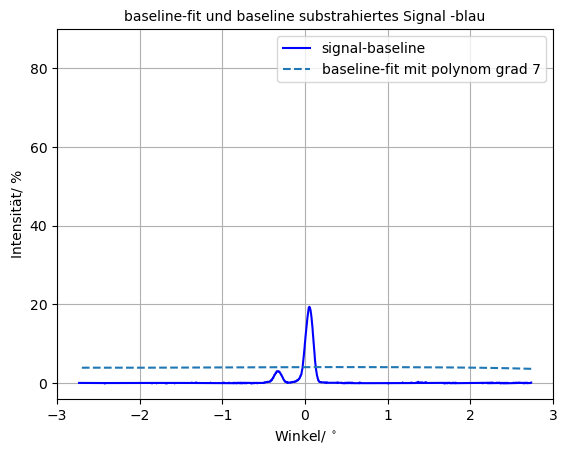

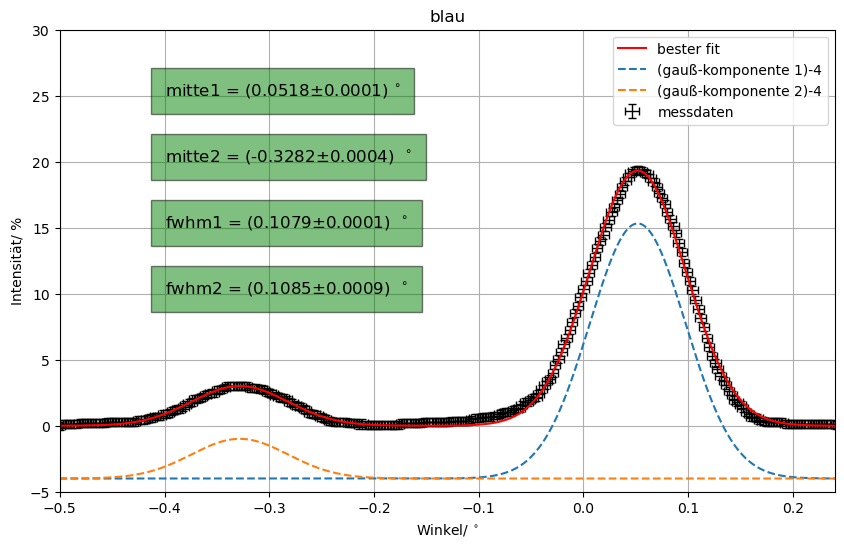

In [5]:
signal_range = [[-0.2,0.1],[-0.03,0.07],[-0.5,0.25]]
achsen=[[-0.20,0.05, -5, 90],[-0.05,0.08, -5, 90],[-0.50,0.24, -5, 30]]
x_err=[0.001,0.001,0.005]
y_err=[1,1.5,0.3]
pos_x=[-0.19,0.03,-0.4]
pos_y=[80,70,25]
pos_y1=[70,60,20]
pos_y2=[60,50,15]
pos_y3=[50,40,10]
titles=['turkis','rot','blau']
deg_polynom=7
lala=[]
lolo=[]

for path in range(0,3):
    def coarseBackgroundModel(x,y,deg,signal_range):
        """
        coarse fit of a polynomial model to the entire data for a first background reduction:
        
        x: v_LSR
        y: T_A
        deg: degree of the polynom to fit to the data
        
        """
        # set up polynomial model
        poly_mod = PolynomialModel(deg, prefix='p1_')
        
        mask= ((x<signal_range[0]) | (x>signal_range[1]))
        x_ = x[mask]
        y_ = y[mask]
        
        # let lmfit guess the parameter values:
        p_bg = poly_mod.guess(y_, x=x_)
        
        # set up our background model (only polynomial here):
        mod_bg = poly_mod
        
        # initialize the model with the guessed parameters:
        init_bg = mod_bg.eval(p_bg, x=x_)
        
        # fit the model:
        out_bg = mod_bg.fit(y_, p_bg, x=x_)
        
        # return results:
        return p_bg, out_bg, mod_bg


    x=winkel[path]
    y=Intensity[path]
    p_bg, out_bg, mod_bg = coarseBackgroundModel(x,y,deg_polynom,signal_range[path])  
    background = mod_bg.eval(p_bg,x=x)
    plt.figure()
    plt.title('baseline-fit und baseline substrahiertes Signal -'+str(titles[path]),fontsize=10)
    plt.plot(winkel[path],Intensity[path]-background,'b-',label='signal-baseline')
    plt.plot(winkel[path],background,'--',label='baseline-fit mit polynom grad 7')
    plt.axis([-3,3, -4, 90])
    plt.xlabel('Winkel/ $^{\circ}$')
    plt.ylabel('Intensität/ %')
    plt.grid()
    plt.legend()
    plt.savefig('roh'+str(titles[path])+'.png')
    plt.show
    y=y-background
    model = (GaussianModel(prefix='g1_') +
            GaussianModel(prefix='g2_'))
    param_rot = model.make_params(g1_amplitude=1,
                                g1_center=0.005,
                                g1_sigma=0.05,
                                g2_amplitude=0.4,
                                g2_center=0.04,
                                g2_sigma=0.01)
    param_blau = model.make_params(g1_amplitude=1,
                                g1_center=0.06,
                                g1_sigma=0.05,
                                g2_amplitude=0.4,
                                g2_center=-0.33,
                                g2_sigma=0.01)
    param_turkis = model.make_params(g1_amplitude=1,
                                g1_center=-0.006,
                                g1_sigma=0.05,
                                g2_amplitude=0.4,
                                g2_center=-0.045,
                                g2_sigma=0.01)
    param=[param_turkis,param_rot,param_blau]
    params=param[path]
    params['g1_amplitude'].set(value=1,min=0.00)
    params['g2_amplitude'].set(value=0.5,min=0.00)
    result = model.fit(y, params, x=x)

    #comps = result.eval_components(x=x)
    lala=[]
    lolo=[]

    for name,param in result.params.items():
        if result.errorbars==True:
            lala.append(param.stderr)
        else:
            lala.append(0)
        lolo.append(param.value)
    ding1=lolo[1]
    ding2=lala[1]
    ding3=lolo[4]
    ding4=lala[4]
    ding5=lolo[6]
    ding6=lala[6]
    ding7=lolo[8]
    ding8=lala[8]

    comps = result.eval_components(x=x)
    dely = result.eval_uncertainty(sigma=3)
    x2=np.linspace(min(x),max(x),10000)
    comps2 = result.eval_components(x=x2)
    result2=result.eval(x=x2)
    ergebniss = model.eval(params,x=x)
    #print(result.params.items)
    plt.figure(figsize=(10,6))
    G3label  = r"mitte1 = $($" + str(np.round(ding1, 4)) + r"$\pm$" + str(np.round(ding2, 4)) + r"$)$ $^{\circ}$"
    plt.text( pos_x[path],pos_y[path], G3label, bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10}, fontsize = 12)
    G4label  = r"mitte2 = $($" + str(np.round(ding3, 4)) + r"$\pm$" + str(np.round(ding4, 4)) + r"$)$  $^{\circ}$"
    plt.text( pos_x[path],pos_y1[path], G4label, bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10}, fontsize = 12)
    G5label  = r"fwhm1 = $($" + str(np.round(ding5, 4)) + r"$\pm$" + str(np.round(ding6, 4)) + r"$)$  $^{\circ}$"
    plt.text( pos_x[path],pos_y2[path], G5label, bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10}, fontsize = 12)
    G6label  = r"fwhm2 = $($" + str(np.round(ding7, 4)) + r"$\pm$" + str(np.round(ding8, 4)) + r"$)$  $^{\circ}$"
    plt.text( pos_x[path],pos_y3[path], G6label, bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10}, fontsize = 12)
    plt.title(str(titles[path]))
    plt.errorbar(winkel[path],Intensity[path]-background, y_err[path],x_err[path],'k.',capsize=3,elinewidth=1,markersize=0, label='messdaten')
    plt.plot(x2, result2, 'r-', label='bester fit')
    plt.plot(x2, comps2['g1_']-4, '--', label='(gauß-komponente 1)-4')
    plt.plot(x2, comps2['g2_']-4, '--', label='(gauß-komponente 2)-4')
    # plt.plot(winkel[1],background)
    plt.xlabel('Winkel/ $^{\circ}$')
    plt.ylabel('Intensität/ %')
    plt.axis(achsen[path])
    plt.grid()
    plt.legend()
    plt.savefig(str(titles[path])+'.png')
    plt.show
    with open('fitparameter'+str(titles[path])+'.txt','w') as f:
        for name in result.best_values:
            f.write(str(name)+'\t'+str(np.round(result.best_values[name],4))+'\n')

    print(result.fit_report(min_correl=0.5))

In [4]:
dictonary=[list() for x in range(20)]
print(dictonary)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
